# Исследование мобильного приложения "Ненужные вещи".
В нашем распоряжении датасет, который содержит данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

# Цель исследования
Подготовить исследование, выделить группы пользователей на основе поведения, проанализировать данные, чтобы приложение для продажи ненужных вещей стало лучшим приложением.


# ДЕКОМПОЗИЦИЯ

1. Загрузка данных, импорт библиотек
2. Предобработка данных:
* Исследовать пропущенные значения;
* Исследовать соответствие типов;
* Исследовать дубликаты;
* Проверить корректность наименований колонок;
* Переименовать колонки;
* Удалить дубликаты;
* Привести типы;
* Заменить пропущенные значения.
3. Исследовательский анализ данных - Анализ общего поведения пользователей и выделение групп EDA:
- Retention rate 
- Время проведенное в приложении (делаем сессии, и смотрим эту метрику)
- Частота действий
- Конверсия в целевое действие — просмотр контактов);
* Просмотр выбросов и аномалий в данных, визуализация;
4. Сегментирование пользователей на основе действий на 3-4 группы:
- Определить пользователи какой группы склонны часто возвращаться в мобильное приложение (для каждой группы считаем Retention rate);
- Определить пользователи какой группы часто делают целевое событие (для каждой группы считаем конверсию в целевое действие);
- Получить гипотезы как можно было бы улучшить приложения с точки зрения пользовательского опыта;
5. Проверить статистические гипотезы:
* Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверить гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.
*  Моя гипотеза - конверсия в целевое действие у пользователей в будние дни и в выходные различается у этих двух групп.
6. Выводы

### Импортируем библиотеки и загрузим данные

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import math as mth
from scipy import stats as st
import time
from datetime import datetime
from datetime import date, timedelta as td

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
display(mobile_sourсes.info())
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


**Вывод** Нужно переименовать названия колонок, чтобы потом объединить датасеты.

### Выполним предобработку данных

In [4]:
# Переименовываем столбцы, смотрим результат
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.columns =['date', 'event_name', 'user_id']
display(mobile_sourсes.info())
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


**Вывод** Все переименовано и в нижнем регистре, далее объединим датасеты, проверим пропуски, дубликаты и приведем данные к нужному типу.

In [5]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left') # объединяем датасеты, проверяем результат
df.head(10)

,date,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other


In [6]:
display(f'Количество дубликатов {df.duplicated().sum()}')#проверка дубликатов
df.isna().sum() # проверка пропусков

'Количество дубликатов 0'

date          0
event_name    0
user_id       0
source        0
dtype: int64

**Вывод** Пропусков и дубликатов не обнаружено. Далее добавим столбец только с датой и изменим тип данных столбцов с датами.

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.round('1S') # округлим время до секунды
df['only_date'] = df['date']
df['only_date'] = df['only_date'].dt.strftime("%Y-%m-%d")
df['only_date'] = pd.to_datetime(df['only_date'], format='%Y-%m-%d')
display(df.head(5))
df.info()

,date,event_name,user_id,source,only_date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
 4   only_date   74197 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 3.4+ MB


**Вывод** Тип изменен, столбец с датой добавлен.

In [8]:
# добавлю столбец с номер дня недели для будущей сегментации, 0 - понедельник и тд.
df['num_day_week'] = df['only_date'].dt.weekday
df.head(5)

,date,event_name,user_id,source,only_date,num_day_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0


In [9]:
df['event_name'].value_counts() # посмотрим какие есть события и сколько их

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

**Вывод** Самое популярное событие - tips_show. А contacts_show  и show_contacts одинаковые, нужно переименовать, чтобы объединить данные.

In [10]:
df.loc[(df.query('event_name == "show_contacts"').index),'event_name'] = "contacts_show"
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

**Вывод** Повторяющихся событий теперь нет

In [11]:
# посмотрим какие есть ресурсы в датасете
df['source'].value_counts()

yandex    34286
google    20445
other     19466
Name: source, dtype: int64

In [12]:
df['user_id'].nunique() # посмотрим количество уникальных пользователей

4293

**Вывод** Датасеты объеденины, дубликатов и пропусков нет, всё приведено в нужный тип и вид. Можно приступать к дальнейшему анализу.

### Выделение групп EDA

#### Retention Rate

In [13]:
# посмотрим какой период даннных в датасете, из описания известно только, что после 07/10/2019
display(df['date'].max())
display(df['date'].min())
'Период =', (df['date'].max() - df['date'].min())

Timestamp('2019-11-03 23:58:13')

Timestamp('2019-10-07 00:00:00')

('Период =', Timedelta('27 days 23:58:13'))

**Вывод** Данные в датасете с 7 октября 2019 года по 3 ноября 2019 всего 28 дней - 3 недели.

In [14]:
# cоздадим столбец с датой первой активности пользователя в приложении

activ_first = df.groupby(['user_id'])['only_date'].min() # берем минимальную дату
activ_first.name = 'start'
df = df.merge(activ_first, on = 'user_id',  how = 'left') # присоединяем эти данные к основному датасету
df['start'] = df['start'].astype('datetime64[D]')
df.head(5)

,date,event_name,user_id,source,only_date,num_day_week,start
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07


**Вывод** В датасете теперь есть столбец с датой первой активности пользователя

In [15]:
# находим кагорту
df['activ_w'] = pd.to_datetime(df['only_date'], unit='d') - pd.to_timedelta(df['only_date'].dt.dayofweek, unit='d')
df['start_w'] = pd.to_datetime(df['start'], unit='d') - pd.to_timedelta(df['start'].dt.dayofweek, unit='d')

In [16]:
# рассчитаем лайфтайм
df['lifetime'] = df['activ_w'] - df['start_w']
df['lifetime'] = df['lifetime'] / np.timedelta64(1,'W')
df['lifetime'] = df['lifetime'].astype(int)
df.head(5)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0


**Вывод** Лайфтай рассчитали, теперь сделаем отдельную таблицу с данными для рассчета retention rate и посчитаем его.

In [17]:
cohorts_lifetime = df.groupby(['start_w','lifetime']).agg({'user_id':'nunique'}).reset_index() # сгруппируем данные по лайфтайму и кагорте
user_count = cohorts_lifetime[cohorts_lifetime['lifetime'] == 0][['start_w','user_id']] # посчитаем количество пользователей на нулевую неделю
user_count = user_count.rename(columns={'user_id':'cohort_user'})
cohorts_lifetime = cohorts_lifetime.merge(user_count,on='start_w')
cohorts_lifetime.head(5)

,start_w,lifetime,user_id,cohort_user
0,2019-10-07,0,1130,1130
1,2019-10-07,1,272,1130
2,2019-10-07,2,170,1130
3,2019-10-07,3,119,1130
4,2019-10-14,0,1166,1166


In [18]:
# посчитаем retention rate
cohorts_lifetime['retention_rate'] = cohorts_lifetime['user_id']/cohorts_lifetime['cohort_user']
cohorts_lifetime['start_w'] = cohorts_lifetime['start_w'].astype('datetime64[D]') 

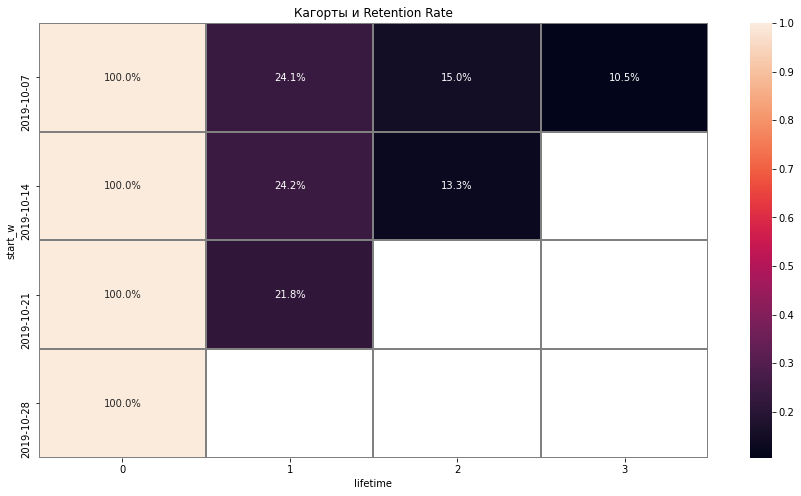

In [20]:
# избавляемся от миллисекунд
cohorts_lifetime['start_w'] = cohorts_lifetime['start_w'].dt.strftime('%Y-%m-%d')

retention_rate = cohorts_lifetime.pivot_table(index='start_w',columns='lifetime',values='retention_rate',aggfunc='sum') # сводная таблица
plt.figure(figsize=(15, 8))
plt.title('Кагорты и Retention Rate')
sns.heatmap(retention_rate, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

**Вывод** Пользователи убывают, кагорта первой недели - осталось только 24% и со временем показатель RR только уменьшается со временем. Такая же ситуация и у остальных кагорт, с течением времени пользователь уходит и не возвращается в приложение.

#### Время, проведенное в приложении

In [20]:
df.sort_values(['user_id', 'date']) # сортируем датасет перед тем как начать выделять сессии
# чтобы определить какую временную метку взять за сессию, сделаем новый столбец с датой предыдущего действия пользователя
df['pred_time'] = df.groupby('user_id')['date'].shift()
# сделаем столбец с промежутком времени между событиями
df['time_session'] = df['date'] - df['pred_time']
df.head(5)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:00,0 days 00:00:01
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:01,0 days 00:00:06
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:02,0 days 00:00:54


In [21]:
display(df['time_session'].describe())
#df.groupby('user_id', 'date')['time_session'].describe()

count                        69904
mean     0 days 03:53:01.169246395
std      1 days 01:32:57.260287392
min                0 days 00:00:00
25%                0 days 00:00:24
50%                0 days 00:01:11
75%                0 days 00:03:00
max               26 days 13:49:55
Name: time_session, dtype: object

**Вывод** Очень большой разброс в длительности сессий от нуля до 26 дней, среднее вообще 3,53 часа, а минимальное значение ноль. Переведем данные времени в минуты и посмотрим данные по графику.

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,NaN
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:00,0 days 00:00:01,0.02
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,NaN
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:01,0 days 00:00:06,0.10
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:02,0 days 00:00:54,0.90


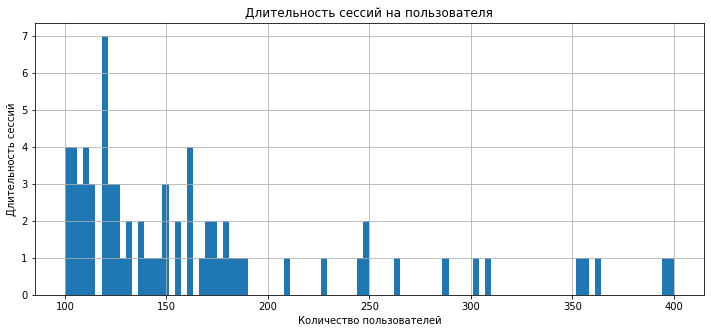

In [22]:
df['session_dlit'] = round((df['time_session'].astype('timedelta64[s]')/60),2) # переведем длительность сессии в минуты
display(df.head(5))

dfh = df.groupby(['user_id'])['session_dlit'].count()
plt.figure(figsize=(12,5))
plt.hist(dfh, bins=100, range=(100,400)) 
plt.xlabel('Количество пользователей')
plt.grid()
plt.ylabel('Длительность сессий')
plt.title('Длительность сессий на пользователя');

**Вывод** По графику видно, что длительность сессий на пользователя в основном 1-2 минуты, но есть и большие показатели на 4 и 7 минут.

No handles with labels found to put in legend.


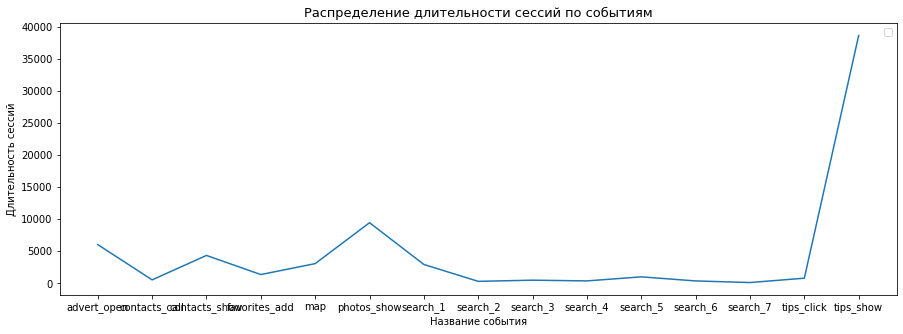

In [23]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby(['event_name'])['session_dlit'].count(), label='')
plt.legend()
plt.title('Распределение длительности сессий по событиям', fontsize=13)
plt.xlabel('Название события')
plt.ylabel('Длительность сессий')
plt.show()

**Вывод** Самое популярное событие по длительности сессий у пользователей это tips_show - 40055. Еще photos_show - 10012, аdvert_open - 6164 и contacts_show - 4529. 

За размер сессиий возьму 75% это 3 минуты, считаю в приложении как авито быстро не получится найти/продать, а за 3 минуты возможно сделать что-то результативное.

In [24]:
df.sort_values(['user_id', 'date']) # сортируем датасет перед тем как начать выделять сессии
# использовала первую ссылку второго подхода из чата Пачки

# Выделим сессии относительно  тайм-аута
df['date'] = pd.to_datetime(df['date'])
#identify difference Min for each group with cumulative sum
g = (df.groupby('user_id')['date'].diff() > pd.Timedelta('30Min')).cumsum()
#create counter of groups
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df.head(3)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,NaN,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07,0 days 00:00:01,0.02,1
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,NaN,2


In [25]:
#считаем длительность сессий
session_time = pd.DataFrame(df.groupby(['user_id', 'session_id'])['date'].
     max() - df.groupby(['user_id', 'session_id'])['date'].min()).reset_index()
# переведем время в минуты
session_time ['session_min'] = round((session_time['date'].astype('timedelta64[s]')/60),2)
session_time

,user_id,session_id,date,session_min
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,101,0 days 00:09:56,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1449,0 days 00:08:27,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11577,0 days 00:01:08,1.13
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11584,0 days 00:07:07,7.12
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11603,0 days 00:02:26,2.43
...,...,...,...,...
26834,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26162,0 days 00:00:26,0.43
26835,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26187,0 days 00:02:18,2.30
26836,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26199,0 days 00:00:49,0.82
26837,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26204,0 days 00:00:00,0.00


In [39]:
# среднее время всех сессий 
user_mean_time = (session_time.groupby(['user_id'])['session_min'].agg('mean').reset_index())
user_mean_time.columns = ['user_id', 'mean']
display(user_mean_time.head(15).sort_values(by='mean', ascending = False))
user_mean_time.head(15).sort_values(by='mean', ascending = True)

,user_id,mean
12,009c0f37-8556-4c72-a007-100e28a37373,16.120000
9,006f6ced-225b-4f9c-9f17-23404bc6835f,9.070000
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4.830000
14,00aa4003-366b-4788-ad1f-506f2b51b8cb,3.280000
8,006a32d4-ee10-40dc-b237-11e0fde81cbc,3.026667
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2.792667
2,00463033-5717-4bf1-91b4-09183923b9df,2.737500
6,005fbea5-2678-406f-88a6-fbe9787e2268,2.415000
7,00653802-5ff1-4071-bc17-347fc4cef569,2.260000
5,00554293-7e00-4122-b898-4e892c4a7c53,1.976667


,user_id,mean
11,007d031d-5018-4e02-b7ee-72a30609173f,0.240000
4,00551e79-152e-4441-9cf7-565d7eb04090,0.717500
13,00a93a72-3bbc-4ee7-8a81-7134f45ae009,0.890000
10,00753c79-ea81-4456-acd0-a47a23ca2fb9,1.060000
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.815714
5,00554293-7e00-4122-b898-4e892c4a7c53,1.976667
7,00653802-5ff1-4071-bc17-347fc4cef569,2.260000
6,005fbea5-2678-406f-88a6-fbe9787e2268,2.415000
2,00463033-5717-4bf1-91b4-09183923b9df,2.737500
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2.792667


**Вывод** По таблицам видно, что среднее время сессий на пользователя максимум  16 минут и минимум 24 секунды, если не считать минимумом нулевую сессию.

In [28]:
df['session_dlit'].fillna('0',inplace=True) #заменяю пропуски на ноль
df['session_dlit'] = df['session_dlit'].astype(float)
df.head(3)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07,0 days 00:00:01,0.02,1
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,2


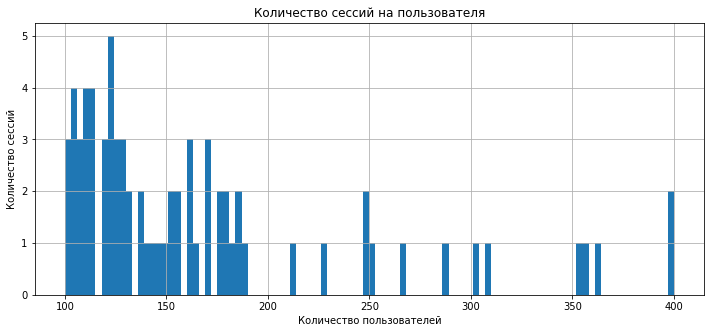

In [26]:
dfhz = df.groupby(['user_id'])['session_id'].count().sort_values(ascending=False)
plt.figure(figsize=(12,5))
plt.hist(dfhz, bins=100, range=(100,400)) 
plt.xlabel('Количество пользователей')
plt.grid()
plt.ylabel('Количество сессий')
plt.title('Количество сессий на пользователя');

**Вывод** по графику видно, что в основном по 1-2 сессии на пользователя, это получается где-то 3-6 минут.

In [27]:
# группирую для дальнейшего графика
user_time_app = (df.groupby(['user_id'])['session_dlit'].agg({'sum', 'median', 'mean'}).reset_index())
user_time_app.columns = ['user_id','sum', 'median', 'mean']
user_time_app.head(10)

,user_id,sum,median,mean
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.280,613.460286,21471.11
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.430,300.529859,21337.62
2,00463033-5717-4bf1-91b4-09183923b9df,1.380,2.471000,24.71
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1.195,584.005000,18688.16
4,00551e79-152e-4441-9cf7-565d7eb04090,1.325,611.566250,4892.53
5,00554293-7e00-4122-b898-4e892c4a7c53,0.670,7.997273,87.97
6,005fbea5-2678-406f-88a6-fbe9787e2268,0.180,2.162000,10.81
7,00653802-5ff1-4071-bc17-347fc4cef569,1.350,1.700000,8.50
8,006a32d4-ee10-40dc-b237-11e0fde81cbc,1.765,2.613333,15.68
9,006f6ced-225b-4f9c-9f17-23404bc6835f,1.180,1.814000,9.07


**Вывод** В данных есть большой разброс, среднее 1.280, а медиана 21471.11 слишком большая разница.

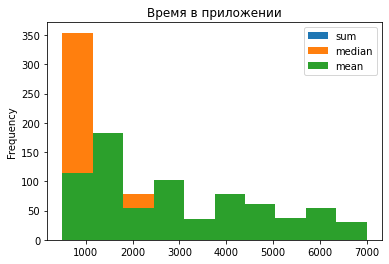

In [28]:
user_time_app.plot(x = 'user_id', y = ['sum', 'median', 'mean'], title = 'Время в приложении', kind='hist', range=(500,7000));

**Вывод** В датасете есть аномалии и выбросы еще и нулевые значения.

In [29]:
df_session_nol = df.query('session_dlit == 0').count() # смотрим количество нулевых сессий и в каких событиях они
display(df_session_nol)
df_session_no_nol = df.query('session_dlit != 0').count() # смотрим количество ненулевых сессий 
df_session_no_nol

date            5550
event_name      5550
user_id         5550
source          5550
only_date       5550
num_day_week    5550
start           5550
activ_w         5550
start_w         5550
lifetime        5550
pred_time       1257
time_session    1257
session_dlit    5550
session_id      5550
dtype: int64

date            68647
event_name      68647
user_id         68647
source          68647
only_date       68647
num_day_week    68647
start           68647
activ_w         68647
start_w         68647
lifetime        68647
pred_time       68647
time_session    68647
session_dlit    68647
session_id      68647
dtype: int64

**Вывод** Из 68647 событий 5550 нулевых, это 8,1% нулевых сессий от общего числа, достаточно большой процент.

#### Частота действий

In [30]:
#Расчитаем частоту действий для пользователей
chastota_d = df.groupby('event_name').agg({'event_name':'count'})# сгрупируем по типам действий 
chastota_d_sum = chastota_d['event_name'].sum() # общее количество событий 
chastota_d = chastota_d.rename(columns={'event_name':'event_na'}).reset_index()
chastota_d['prozent'] = 100*(chastota_d['event_na']/chastota_d_sum) # рассчитаем в процентах
chastota_d.sort_values(by='event_na', ascending=False)


,event_name,event_na,prozent
14,tips_show,40055,53.984662
5,photos_show,10012,13.493807
0,advert_open,6164,8.307614
2,contacts_show,4529,6.104020
4,map,3881,5.230670
6,search_1,3506,4.725258
3,favorites_add,1417,1.909781
10,search_5,1049,1.413804
13,tips_click,814,1.097079
9,search_4,701,0.944782


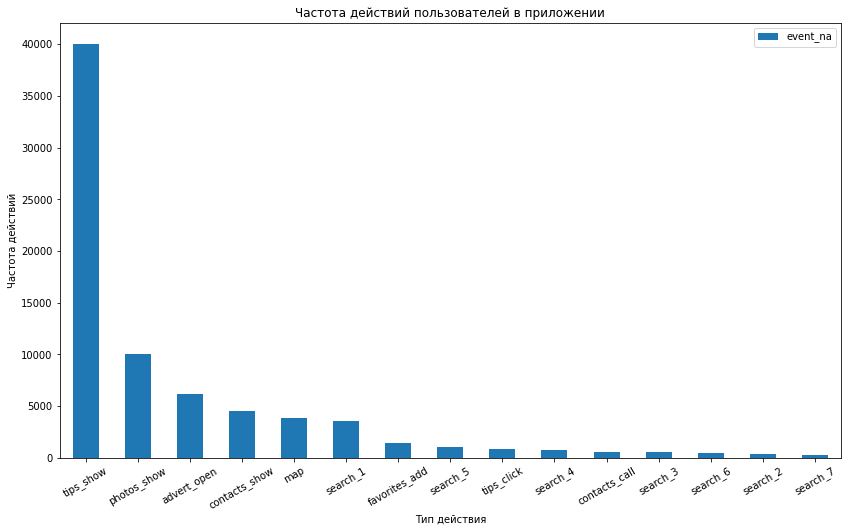

In [31]:
ax = chastota_d.sort_values(by='event_na', ascending=False).plot(kind='bar', x= 'event_name', y= 'event_na',figsize=(14,8)) 
ax.set_title('Частота действий пользователей в приложении')
ax.set_xlabel('Тип действия')
ax.set_ylabel('Частота действий')
plt.xticks(rotation=30)
plt.show()

**Вывод** По длительности ссесий и по частоте самое популярное событие - tips_show, далее photos_show, аdvert_open и contacts_show. 

In [32]:
df['num_day_week'].nunique() # проверю все ли дни недели есть в столбце

7

In [33]:
chastota_po_dnam_nedeli = df.groupby('num_day_week')['event_name'].count().sort_values(ascending=False)
chastota_po_dnam_nedeli

num_day_week
0    11671
1    11145
2    10994
3    10763
6    10501
4     9969
5     9154
Name: event_name, dtype: int64

**Вывод** в пятницу и субботу немного меньше событий, чем в другие дни. Посмотрим наглядно на графике.

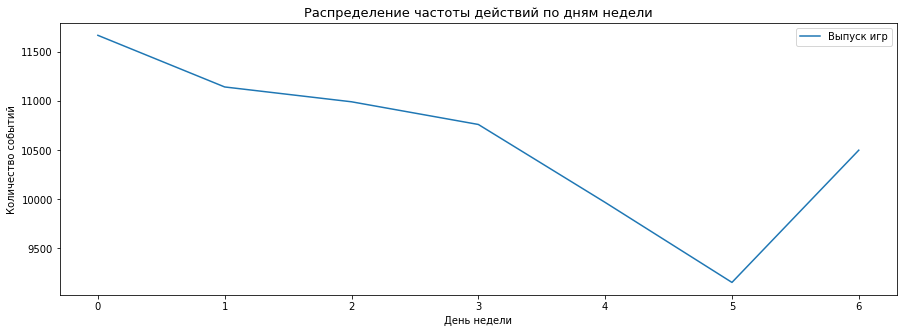

In [34]:
# построим график
plt.figure(figsize=(15,5))
plt.plot(df.groupby(['num_day_week'])['event_name'].count(), label='Выпуск игр')
plt.legend()
plt.title('Распределение частоты действий по дням недели', fontsize=13)
plt.xlabel('День недели')
plt.ylabel('Количество событий')
plt.show()

**Вывод** Начиная с понедельника идет плавный спад, с четверга по субботу резкий спад, далее подъем. Возможно это связано с выходными, пользователи меньше пользуются приложением в пятницу и субботу.

In [35]:
chastota_po_dnam_nedeli_7 = df.pivot_table(index = 'only_date', values = 'event_name', aggfunc = 'count').sort_values(by = 'event_name', ascending=False)
chastota_po_dnam_nedeli_7.reset_index()
chastota_po_dnam_nedeli_7[ '7day_rolling_avg' ] = chastota_po_dnam_nedeli_7.event_name.rolling(7).mean()
chastota_po_dnam_nedeli_7.reset_index()

,only_date,event_name,7day_rolling_avg
0,2019-10-23,3360,NaN
1,2019-10-29,3196,NaN
2,2019-10-28,3184,NaN
3,2019-10-26,3127,NaN
4,2019-10-14,3034,NaN
5,2019-10-24,3034,NaN
6,2019-10-21,2908,3120.428571
7,2019-10-30,2877,3051.428571
8,2019-10-31,2868,3004.571429
9,2019-10-27,2861,2958.428571


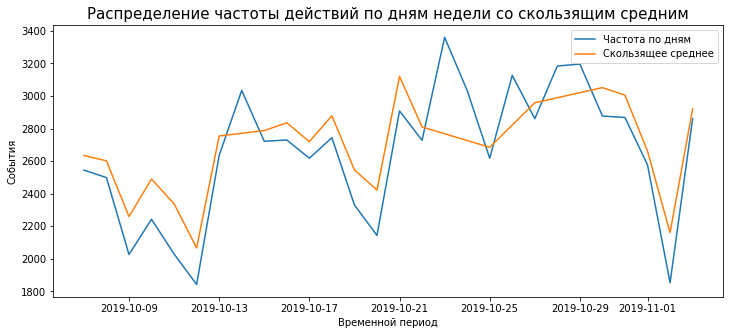

In [36]:

# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'only_date',
             y = 'event_name',
             data = chastota_po_dnam_nedeli_7,
             label = 'Частота по дням')
  
# plot using rolling average
sns.lineplot( x = 'only_date',
             y = '7day_rolling_avg',
             data = chastota_po_dnam_nedeli_7,
             label = 'Скользящее среднее')
plt.title('Распределение частоты действий по дням недели со скользящим средним', fontsize=15)  
plt.xlabel('Временной период')
plt.ylabel('События');

#### Конверсия в целевое действие - просмотр контакта

In [37]:
# для расчета конверсии в цд, сделаем срез по событию и посчитаем количество уникальных пользователей
contact_show = df.query('event_name == "contacts_show"')
contact_show['user_id'].nunique()

981

In [38]:
# посчитаем конверсию, разделим количество уникальных пользователей, совершивших целевое действие на общее количество уникальных пользователей
conversion_contacts_show = (contact_show['user_id'].nunique() / df['user_id'].nunique()) * 100
conversion_contacts_show

22.851153039832283

**Вывод** Конверсия в целевое действие уникальных пользователей приложения - 22.85%. Почти 23% пользователей просматривают контакт.

**Вывод по разделу** Пользователей возвращается все меньше и меньше с каждой неделей использования приложения, от 100% на вторую неделю вернулось 24%, далее через неделю - 15%, на четвертой неделе осталось 10.5%. Дольше всего по времени пользователи просматривают рекомендованные объявления. Чаще всего приложением пользуются с понедельника по четверг, далее идет резкий спад и только в субботу начинается постепенный подъем активности. Коверсия пользователей, совершивших событие "запрос контакта" почти 23%.

### Сегментация пользователей

Определить пользователи какой группы склонны часто возвращаться в мобильное приложение (для каждой группы считаем Retention rate);
Определить пользователи какой группы часто делают целевое событие (для каждой группы считаем конверсию в целевое действие);
Получить гипотезы как можно было бы улучшить приложения с точки зрения пользовательского опыта;

Решила сегментировать пользователей по времени событий на утро, день, вечер и ночь. Чтобы посмотреть в какой период наиболее активен пользователь в приложение, а в какое время пользователь не использует приложение и это будет полезно для планирования дальнейшего развития приложения. Предположу, что в вечернее время больше пользователей, чем утром, так как после работы люди чаще используют свой смартфон.

In [39]:
df['event_name'].value_counts().nunique

<bound method IndexOpsMixin.nunique of tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64>

In [40]:
df['hour'] = df['date'].dt.hour #сделаю столбец ч временем отдельно, чтобы сегментировать пользователей по времени событий утро, день, вечер, ночь
display(df.head(5))
df['hour'].nunique()

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit,session_id,hour
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,1,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:00,0 days 00:00:01,0.02,1,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,2,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:01,0 days 00:00:06,0.10,1,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07 00:00:02,0 days 00:00:54,0.90,2,0


24

Сделаю группы пользователей:
- Утро с 5 до 11 часов ГРУППА А
- День с 11 до 15 часов ГРУППА B
- Вечер с 15 до 23 часов ГРУППА C
- Ночь с 23 до 5 часво ГРУППА D

In [41]:
def categorize_time (hour): # создайте функцию categorize_income()
    if hour >= 23 and hour < 5:
        return 'D'
    if hour >= 15 and hour < 23:
        return 'C'
    if hour >= 11 and hour < 15:
        return 'B'
    return 'A'

In [42]:
df['time_category'] = df['hour'].apply(categorize_time) # добавляем в датасет данные категорий
df.head(3)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit,session_id,hour,time_category
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,1,0,A
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07,0 days 00:00:01,0.02,1,0,A
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,2,0,A


In [43]:
#сделаю отдельные датасеты по группам через срез данных
df_group_a = df.query('time_category == "A"')
df_group_b = df.query('time_category == "B"')
df_group_c = df.query('time_category == "C"')
df_group_d = df.query('time_category == "D"')

In [44]:
display(df['user_id'].nunique()) # посмотрим количество уникальных пользователей
df_contact_show = df_group_a.query('event_name == "contacts_show"')
df_contact_show['user_id'].nunique() # посмотрим количество уникальных пользователей совершивших целевое действие

4293

267

In [45]:
# для расчета конверсии в целевое действие, отфильтруем датасет по событию и посчитаем количество уникальных пользователей
df_group_a_contact_show = df_group_a.query('event_name == "contacts_show"')
df_group_a_contact_show['user_id'].nunique()
# посчитаем конверсию, разделим количество уникальных пользователей, совершивших целевое действие на общее количество уникальных пользователей
conversion_contacts_show_a = (df_group_a_contact_show['user_id'].nunique() / df_group_a['user_id'].nunique()) * 100

df_group_b_contact_show = df_group_b.query('event_name == "contacts_show"')
df_group_b_contact_show['user_id'].nunique()
conversion_contacts_show_b = (df_group_b_contact_show['user_id'].nunique() / df_group_b['user_id'].nunique()) * 100

df_group_c_contact_show = df_group_c.query('event_name == "contacts_show"')
df_group_c_contact_show['user_id'].nunique()
conversion_contacts_show_c = (df_group_c_contact_show['user_id'].nunique() / df_group_c['user_id'].nunique()) * 100

df_group_d_contact_show = df_group_d.query('event_name == "contacts_show"')
df_group_d_contact_show['user_id'].nunique() # посмотрим количество пользователей в группе D

0

In [46]:
# проверяю количество пользователей уникальных в каждой из групп для расчета конверсии
display(df_group_a_contact_show['user_id'].nunique())
display(df_group_b_contact_show['user_id'].nunique())
display(df_group_c_contact_show['user_id'].nunique())
df_group_d_contact_show['user_id'].nunique()

267

395

600

0

**Вывод** В группе D нет уникальных пользователей, значит эту группу пользователей (ночь с 23 до 5 утра) проверять не буду.

In [47]:
display(f'Конверсия группы А составляет', conversion_contacts_show_a)
display(f'Конверсия группы B составляет', conversion_contacts_show_b)
display(f'Конверсия группы C составляет', conversion_contacts_show_c)

'Конверсия группы А составляет'

16.47131400370142

'Конверсия группы B составляет'

22.253521126760564

'Конверсия группы C составляет'

21.156558533145276

**Вывод** Конверсия группы А утро с 5 до 11 часов ниже, чем у остальных групп, 16,5%, группы день и вечер почти с одинаковым результатом - 22,25% и 21,16%. Значит пользователи группы день и вечер чаще совершают целевое действие в приложении.

**Посчитаем Retention Rate для наших групп**

In [48]:
# сделаем новую таблицы для расчета RR, добавим столбец с категориями группы для дальнейшего среза
cohorts_lifetime_group = df.groupby(['start_w','lifetime', 'time_category']).agg({'user_id':'nunique'}).reset_index() # сгруппируем данные по лайфтайму и кагорте
user_count_group = cohorts_lifetime_group[cohorts_lifetime_group['lifetime'] == 0][['start_w','user_id']] # посчитаем количество пользователей на нулевую неделю
user_count_group = user_count_group.rename(columns={'user_id':'cohort_user'})
cohorts_lifetime_group = cohorts_lifetime_group.merge(user_count,on='start_w')
cohorts_lifetime_group.head(5)

,start_w,lifetime,time_category,user_id,cohort_user
0,2019-10-07,0,A,353,1130
1,2019-10-07,0,B,414,1130
2,2019-10-07,0,C,687,1130
3,2019-10-07,1,A,115,1130
4,2019-10-07,1,B,109,1130


In [49]:
# разделяю на группы
cohorts_lifetime_group_a = cohorts_lifetime_group.query('time_category == "A"')
cohorts_lifetime_group_b = cohorts_lifetime_group.query('time_category == "B"')
cohorts_lifetime_group_c = cohorts_lifetime_group.query('time_category == "C"')
cohorts_lifetime_group_a.head(5) #проверю результат

,start_w,lifetime,time_category,user_id,cohort_user
0,2019-10-07,0,A,353,1130
3,2019-10-07,1,A,115,1130
6,2019-10-07,2,A,63,1130
9,2019-10-07,3,A,42,1130
12,2019-10-14,0,A,404,1166


In [50]:
# посчитаем retention rate группы А
cohorts_lifetime_group_a['retention_rate'] = cohorts_lifetime_group_a['user_id']/cohorts_lifetime_group_a['cohort_user']
cohorts_lifetime_group_a['start_w'] = cohorts_lifetime_group_a['start_w'].astype('datetime64[D]') 

# посчитаем retention rate группы В
cohorts_lifetime_group_b['retention_rate'] = cohorts_lifetime_group_b['user_id']/cohorts_lifetime_group_b['cohort_user']
cohorts_lifetime_group_b['start_w'] = cohorts_lifetime_group_b['start_w'].astype('datetime64[D]') 

# посчитаем retention rate группы С
cohorts_lifetime_group_c['retention_rate'] = cohorts_lifetime_group_c['user_id']/cohorts_lifetime_group_c['cohort_user']
cohorts_lifetime_group_c['start_w'] = cohorts_lifetime_group_c['start_w'].astype('datetime64[D]') 

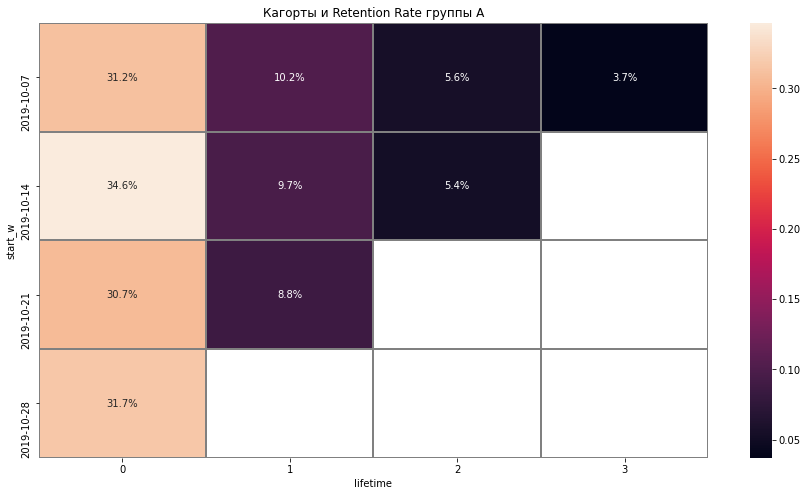

In [51]:
# избавляемся от миллисекунд
cohorts_lifetime_group_a['start_w'] = cohorts_lifetime_group_a['start_w'].dt.strftime('%Y-%m-%d')
# Построим тептовые карты для групп
retention_rate_a = cohorts_lifetime_group_a.pivot_table(index='start_w',columns='lifetime',values='retention_rate',aggfunc='sum') # сводная таблица
plt.figure(figsize=(15, 8))
plt.title('Кагорты и Retention Rate группы А')
sns.heatmap(retention_rate_a, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

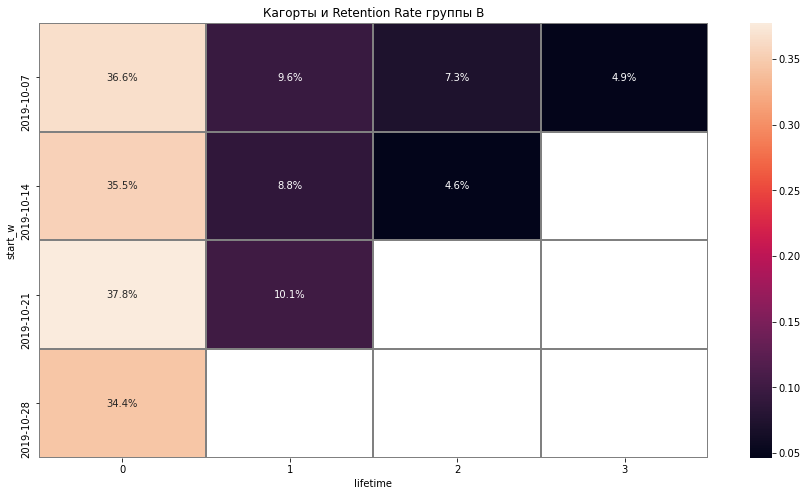

In [52]:
# избавляемся от миллисекунд
cohorts_lifetime_group_b['start_w'] = cohorts_lifetime_group_b['start_w'].dt.strftime('%Y-%m-%d')
retention_rate_b = cohorts_lifetime_group_b.pivot_table(index='start_w',columns='lifetime',values='retention_rate',aggfunc='sum') # сводная таблица
plt.figure(figsize=(15, 8))
plt.title('Кагорты и Retention Rate группы В')
sns.heatmap(retention_rate_b, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

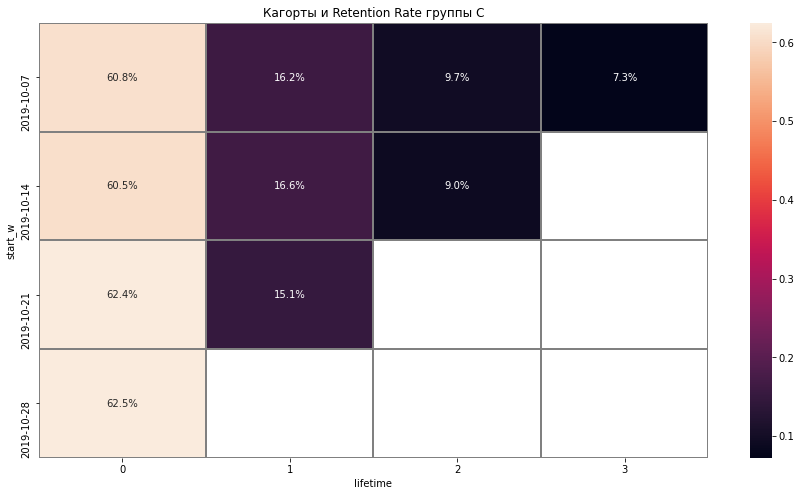

In [53]:
# избавляемся от миллисекунд
cohorts_lifetime_group_c['start_w'] = cohorts_lifetime_group_c['start_w'].dt.strftime('%Y-%m-%d')

retention_rate_c = cohorts_lifetime_group_c.pivot_table(index='start_w',columns='lifetime',values='retention_rate',aggfunc='sum') # сводная таблица
plt.figure(figsize=(15, 8))
plt.title('Кагорты и Retention Rate группы С')
sns.heatmap(retention_rate_c, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

**Вывод** у третьей группы пользователи вечер с 15 до 23 часов показатель удержания лучше, они чаще возвращаются в приложение, возможно потому что пользуются им в нерабочее время, когда более свободны и внимательны. Группы утро и день - результат хуже.

### Проверка статистических гипотез

#### Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверить гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

Для проверки сформулируем гипотезы:
* Нулевая гипотеза Н0 - конверсия в просмотры контактов пользователей yandex и google у двух групп одинакова.
* Альтернативная гипотеза Н1 - пользователи yandex и google демонстируют разную конверсию в просмотры, в их долях есть значимая разница.

In [54]:
sourse_us = df.query('source !="other"').groupby('source')['user_id'].nunique()
sourse_us

source
google    1129
yandex    1934
Name: user_id, dtype: int64

In [55]:
# сделаем cрез
users_gycontshow = df.query('event_name == "contacts_show" and source !="other"')
# сводную таблицу по нужным нам пользователям
users_gycontshow = users_gycontshow.pivot_table(index='source', columns='event_name', values='user_id', aggfunc='nunique').reset_index()
users_gycontshow['user_count'] = users_gycontshow['source'].apply(lambda x: sourse_us.loc[x])
users_gycontshow = users_gycontshow.set_index('source')
users_gycontshow.columns = ['contacts_show', 'user_count']
users_gycontshow

,contacts_show,user_count
source,,
google,275,1129
yandex,478,1934


In [56]:
alpha = .05 # уровень статистической значимости

successes = (np.array([users_gycontshow['contacts_show'].values[0], 
                     users_gycontshow['contacts_show'].values[1]]))

trials = (np.array([users_gycontshow['user_count'].values[0],
                  users_gycontshow['user_count'].values[1]]))
# пропорция успехов в первой группе:
p1 = successes[0] / trials[0]
# пропорция успехов во второй группе:
p2 = successes[1] / trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод** p-value 0.82 подтверждается нулевая гипотеза о том, что конверсия в просмотры контактов пользователей yandex и google у двух групп одинакова.

#### Вторая гипотеза для проверки "Конверсия в целевое действие у пользователей в будние дни и в выходные различается у этих двух групп".

Для проверки сформулируем гипотезы:
* Нулевая гипотеза Н0 - конверсия в просмотры контактов у пользователей в будни и в выходные дни одинакова.
* Альтернативная гипотеза Н1 - у пользователей разная конверсия в просмотры контактов в будни и в выходные дни, в их долях есть значимая разница.

In [57]:
# через функцию разделю пользователей на будни и выходные дни
def seg_bud_vux (num_day_week): 
    if num_day_week >= 0 and num_day_week <= 4:
        return 'BYD'
    return 'VYX'

In [58]:
df['test_category'] = df['num_day_week'].apply(seg_bud_vux) # добавляем в датасет столбец с новыми категориями
df.head(3)

,date,event_name,user_id,source,only_date,num_day_week,start,activ_w,start_w,lifetime,pred_time,time_session,session_dlit,session_id,hour,time_category,test_category
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,1,0,A,BYD
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,2019-10-07,0 days 00:00:01,0.02,1,0,A,BYD
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,2019-10-07,2019-10-07,2019-10-07,0,NaT,NaT,0.00,2,0,A,BYD


In [59]:
bud_vyx_us = df.groupby('test_category')['user_id'].nunique() # таблица с пользователями по новым категориям
bud_vyx_us

test_category
BYD    3465
VYX    1562
Name: user_id, dtype: int64

In [60]:
# сделаем cрез
users_b_v = df.query('event_name == "contacts_show"')
# сводную таблицу по нужным нам пользователям
users_b_v = users_b_v.pivot_table(index='test_category', columns='event_name', values='user_id', aggfunc='nunique').reset_index()
users_b_v['user_count'] = users_b_v['test_category'].apply(lambda x: bud_vyx_us.loc[x])
users_b_v = users_b_v.set_index('test_category')
users_b_v.columns = ['contacts_show', 'user_count']
users_b_v

,contacts_show,user_count
test_category,,
BYD,768,3465
VYX,318,1562


In [61]:
alpha = .05 # уровень статистической значимости

successes = (np.array([users_b_v['contacts_show'].values[0], 
                     users_b_v['contacts_show'].values[1]]))
trials = (np.array([users_b_v['user_count'].values[0],
                  users_b_v['user_count'].values[1]]))
# пропорция успехов в первой группе:
p1 = successes[0] / trials[0]
# пропорция успехов во второй группе:
p2 = successes[1] / trials[1]
# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.14988552302320435
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод** P-value 0.15, значит подтверждается нулевая гипотеза о равенстве групп, получается в долях пользователей будни/выходные значимой разницы нет.

### Выводы

1. С каждой неделей использования приложения всё меньеш пользователи возвращаются, надо поработать с удержанием пользователей, создавать ценность и мотивацию, чтоб пользователь хотел использовать приложение регулярно.
2. Больше всего времени пользователи тратят на просмотр рекомендованных объявлений при этом целевое действие совершают в 8 раз реже, возможно рекомендации не очень отвечают интересам и запросам пользователей. Просматривают много, а запрашивают контакт редко. Следует проработать алгоритм  рекомендаций объявлений, чтобы они стали боллее целевыми для пользователя.
3. Среднее время сессии пользователя в приложении составляет 16 минут. Чаще пользуются приложением в период с понедельника по четверг, далее идет спад активности пользователей в приложении, рост начинается только в субботу.
4. При сегментации пользователей по времени событий на утро, день, вечер. Исследование показало, что пользователи наиболее активны с 11 до 23 часов (Группа В - 22.25%, группа С - 21.16%). До 11 часов конверсия не намного ниже (16.47%), а в ночное время с 23 до 5 утра активности вообще нет.
5. Все действия по привлечению, удержанию пользователей возможно стоит устраивать в периоды активности: с 11 утра до 11 вечера с понедельника по четверг. 
6. При проверке гипотез, тест показал, что конверсия в просмотр контакта у групп с разными источниками Google и Яндекс одинакова и группы не имеют различий. Значит не стоит убирать какой-то из этих источников. В конверсии - будни/выходные, статистически значимых различий у групп не выявлено. 
